# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [153]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [4]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/128104/1272-128104-0000.flac"

In [5]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [6]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [7]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

In [8]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

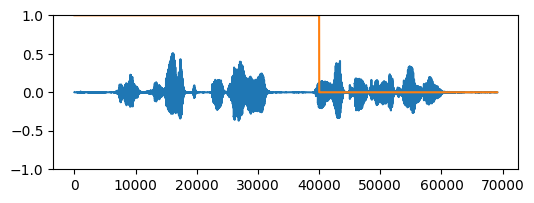

In [9]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [11]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [12]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [13]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [14]:
inputs = inputs2   # use the batch

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [9]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [10]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)

In [11]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"

In [139]:
hf_model = SpeechT5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [140]:
hf_model.eval()

SpeechT5ForConditionalGeneration(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithSpeechPrenet(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=F

In [141]:
# Loading should work OK for class `SpeechT5Model` too:
hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr were not used when initializing SpeechT5Model: ['speecht5.encoder.prenet.feature_projection.projection.weight', 'speecht5.encoder.prenet.feature_encoder.conv_layers.6.conv.weight', 'speecht5.encoder.prenet.feature_projection.projection.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.5.conv.weight', 'speecht5.encoder.prenet.feature_encoder.conv_layers.1.conv.weight', 'speecht5.encoder.prenet.pos_sinusoidal_embed.weights', 'speecht5.encoder.prenet.masked_spec_embed', 'speecht5.encoder.prenet.feature_encoder.conv_layers.2.conv.weight', 'text_decoder_postnet.lm_head.weight', 'speecht5.decoder.prenet.embed_positions.weights', 'speecht5.encoder.prenet.feature_projection.layer_norm.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.layer_norm.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.conv.weight', 'speecht5.encoder.prenet.pos_conv_em

In [142]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [143]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

tuple

In [144]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [145]:
# list(hf_outputs.keys())

In [146]:
# hf_outputs["extract_features"].shape

In [147]:
# hf_outputs["extract_features"]

In [148]:
# hf_outputs["hidden_states"].shape

In [149]:
# hf_outputs["hidden_states"]

In [150]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([1, 215, 768]), torch.Size([1, 215])]

In [151]:
hf_outputs[0]

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.7907, -6.4359,  5.6191,  ...,  0.0352,  3.1737,  0.4928],
         [-0.1691, -4.2425,  6.3816,  ..., -1.6755,  1.3843,  0.2407],
         [ 2.0105, -3.1966,  7.5800,  ..., -0.5673,  1.7153,  0.5722]]])

In [152]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[1]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [25]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [26]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [27]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [28]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [29]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [30]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [31]:
#list(checkpoint["model"].keys())

In [32]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [33]:
# orig_model.decoder.layers[0].encoder_attn

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [34]:
source = inputs["input_values"]
source.shape

torch.Size([1, 69120])

In [35]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [36]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ...,  True,  True,  True]])

In [37]:
# This doesn't work on the original model
#padding_mask = None

In [38]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [39]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [40]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 215, 768]), torch.Size([1, 215]))

In [41]:
encoder_input

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.7907, -6.4359,  5.6191,  ...,  0.0352,  3.1737,  0.4928],
         [-0.1691, -4.2425,  6.3816,  ..., -1.6755,  1.3843,  0.2407],
         [ 2.0105, -3.1966,  7.5800,  ..., -0.5673,  1.7153,  0.5722]]])

In [42]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [43]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(1.)

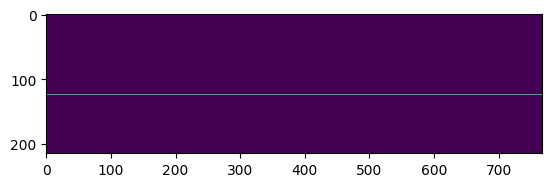

In [44]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

The line that is different is where the padding mask goes from 1 to 0; the original model handles this a little different than we do.

In [45]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [46]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [47]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [48]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [49]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([215, 1, 768])
encoder_padding_mask shape torch.Size([1, 215])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([215, 1, 81])


In [50]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]])

In [51]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.6748,  -9.7322,  -9.7790,  ...,  -9.7432,  -9.6151,  13.2914],
         [-10.0331, -10.0065, -10.1315,  ..., -10.1021, -10.0029,  13.9544],
         [-11.2495, -11.2236, -11.2750,  ..., -11.3193, -11.2077,  15.5090],
         ...,
         [-11.1690, -11.4812, -11.2688,  ..., -11.4284, -11.0229,   8.8438],
         [-10.9783, -11.2885, -11.0654,  ..., -11.2347, -10.7493,   8.8235],
         [-10.5381, -10.8706, -10.7067,  ..., -10.7471, -10.3071,   8.5327]]])

In [52]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [53]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=hf_encoder_attention_mask,
#          input_values=inputs.input_values,
#          attention_mask=inputs.attention_mask,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [54]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]]), hidden_states=None, attentions=None)

In [55]:
list(hf_outputs.keys())

['last_hidden_state']

In [56]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 215, 768])

In [57]:
hf_outputs["last_hidden_state"]

tensor([[[-0.3807, -0.1815, -0.5548,  ...,  0.3614, -0.8483,  0.2265],
         [-0.3834, -0.1535, -0.6543,  ...,  0.2798, -0.9170,  0.1041],
         [-0.4408, -0.1220, -0.7244,  ...,  0.2857, -0.8230, -0.0304],
         ...,
         [-0.4740, -0.2646, -0.1816,  ...,  0.2346, -0.3932,  0.2151],
         [-0.4529, -0.3011, -0.0495,  ...,  0.1883, -0.3702,  0.3084],
         [-0.4112, -0.3328, -0.2101,  ...,  0.2243, -0.3563,  0.1865]]])

In [58]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(0.)

## Verify CTC model

This model only needs the encoder portion.

This uses the same checkpoint as before: `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Run the following to convert, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task ctc \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [59]:
# hf_model_ctc = SpeechT5ForCTC(config)

In [114]:
model_checkpoint_ctc = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc"
hf_model_ctc = SpeechT5ForCTC.from_pretrained(model_checkpoint_ctc)

In [115]:
# This should also work:
hf_model_ctc_naked = SpeechT5Model.from_pretrained(model_checkpoint_ctc)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc were not used when initializing SpeechT5Model: ['speecht5.encoder.prenet.feature_projection.projection.weight', 'speecht5.encoder.prenet.feature_encoder.conv_layers.6.conv.weight', 'speecht5.encoder.prenet.feature_encoder.conv_layers.5.conv.weight', 'speecht5.encoder.prenet.feature_projection.projection.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.1.conv.weight', 'speecht5.encoder.prenet.pos_sinusoidal_embed.weights', 'speecht5.encoder.prenet.masked_spec_embed', 'speecht5.encoder.prenet.feature_encoder.conv_layers.2.conv.weight', 'speecht5.encoder.prenet.feature_projection.layer_norm.bias', 'lm_head.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.layer_norm.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.conv.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_v', 'speecht5.encoder.prenet.feature_encoder.conv_layers.4

In [116]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model_ctc(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model_ctc(input_values=inputs["input_values"])

type(hf_outputs)

transformers.modeling_outputs.CausalLMOutput

In [117]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(0.)

In [118]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [119]:
probs

tensor([[80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4, 46, 80, 80, 16, 80, 80, 12, 12,  6,  6, 80, 80, 80, 80,
         80,  4,  4,  4,  6,  6, 11, 11, 13, 13, 13, 80, 16, 16, 80, 80, 80, 80,
         12, 12,  6,  6, 80, 80, 80, 80, 80, 80, 80, 80,  4,  4,  4, 80, 80,  7,
          9, 14, 14,  4,  4, 80, 24, 80, 80, 80, 80,  5, 80, 13, 13, 13, 13, 13,
         80, 22, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,  4,  4,  4, 80, 80,  9, 14,
         14, 14, 14, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]])

In [120]:
# print(tgt_dict.string(probs[0]))

In [121]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))
    print("")

                jusstt   tthhrrruusstt   andd  perrrrry   ndddd



Calculate loss:

In [68]:
with torch.no_grad():
     hf_outputs = hf_model_ctc(
         **inputs, 
         labels=torch.tensor(
           [[ 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13, ]]
         ),
         output_hidden_states=True,
         return_dict=True,
     )

In [69]:
hf_outputs.loss

tensor(867.8440)

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [70]:
batch_size = inputs.input_values.size(0)
beam_size = 5

In [71]:
tokens = torch.tensor([2, 4, 46, 16, 12, 16] * beam_size * batch_size).reshape(beam_size * batch_size, -1)
tokens.shape

torch.Size([5, 6])

In [72]:
# This one has padding (token_id = 1)
# The results will be different with the HF implementation because
# we don't set the attention_mask to 0 for padding tokens
# tokens = torch.tensor([2, 4, 46, 16, 1, 12] * beam_size * batch_size).reshape(beam_size * batch_size, -1)

In [73]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state=None)

In [74]:
# This returns a sequence length of 1
# with torch.no_grad():
#     prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state={})

In [75]:
# Note: misleading name; these are not the actual tokens but their embeddings!
prev_output_tokens.shape

torch.Size([5, 6, 768])

In [76]:
tgt_mask

In [77]:
incremental_state

In [78]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_ids=tokens,
#          attention_mask=hf_encoder_attention_mask,
#          attention_mask=inputs.attention_mask,
#          past_key_values=[(torch.ones(5, 1, 1), torch.ones(5, 1, 1))],
     )

type(hf_outputs)

tuple

In [79]:
token_embeds_hf, decoder_attention_mask = hf_outputs

In [80]:
token_embeds_hf.shape

torch.Size([5, 6, 768])

In [81]:
torch.max(torch.abs(prev_output_tokens - token_embeds_hf))

tensor(0.)

In [82]:
decoder_attention_mask

## Verify Transformer decoder output

In [83]:
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [84]:
prev_output_tokens

tensor([[[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
  

In [85]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [86]:
decoder_output.shape

torch.Size([5, 6, 768])

In [87]:
decoder_output

tensor([[[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
         [-0.0151, -0.1364, -0.4223,  ...,  0.3197, -0.2469,  0.1624],
         [ 0.9742, -0.4636, -1.4084,  ...,  0.2529,  0.2293, -0.4467],
         [ 0.6141, -0.4535, -0.1964,  ..., -0.4525, -0.1346, -0.5909],
         [ 0.8822, -0.4557, -0.7624,  ...,  0.0964,  0.2632, -0.3568]],

        [[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
         [-0.0151, -0.1364, -0.4223,  ...,  0.3197, -0.2469,  0.1624],
         [ 0.9742, -0.4636, -1.4084,  ...,  0.2529,  0.2293, -0.4467],
         [ 0.6141, -0.4535, -0.1964,  ..., -0.4525, -0.1346, -0.5909],
         [ 0.8822, -0.4557, -0.7624,  ...,  0.0964,  0.2632, -0.3568]],

        [[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
  

In [88]:
#[x.shape for x in extra["attn"]]

In [89]:
#[x.shape for x in extra["inner_states"]]

In [90]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_outs["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [91]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [92]:
hf_outputs["last_hidden_state"].shape

torch.Size([5, 6, 768])

In [93]:
hf_outputs["last_hidden_state"]

tensor([[[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
         [-0.0151, -0.1364, -0.4223,  ...,  0.3197, -0.2469,  0.1624],
         [ 0.9742, -0.4636, -1.4084,  ...,  0.2529,  0.2293, -0.4467],
         [ 0.6141, -0.4535, -0.1964,  ..., -0.4525, -0.1346, -0.5909],
         [ 0.8822, -0.4557, -0.7624,  ...,  0.0964,  0.2632, -0.3568]],

        [[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
         [-0.0151, -0.1364, -0.4223,  ...,  0.3197, -0.2469,  0.1624],
         [ 0.9742, -0.4636, -1.4084,  ...,  0.2529,  0.2293, -0.4467],
         [ 0.6141, -0.4535, -0.1964,  ..., -0.4525, -0.1346, -0.5909],
         [ 0.8822, -0.4557, -0.7624,  ...,  0.0964,  0.2632, -0.3568]],

        [[-0.4313, -0.3359, -0.2130,  ..., -0.2689, -0.3691, -0.0400],
         [-0.2194, -0.0034, -0.7280,  ..., -0.1523, -0.6537,  0.0089],
  

In [94]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(1.1325e-06)

## Verify text decoder postnet output

In [95]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [96]:
lprobs.shape

torch.Size([5, 6, 81])

In [97]:
lprobs[0]

tensor([[-2.1037e+01, -2.1807e+01,  1.5759e+00, -2.1707e+01,  1.6257e+01,
          7.1087e-02,  1.8325e-01, -1.0547e+00, -1.7248e-01, -1.9979e+00,
         -5.4946e-02,  1.3188e-01, -2.4018e-01, -1.1039e+00, -2.6584e+00,
         -1.0886e+00, -1.0818e+00, -2.0889e+00, -1.1437e+00, -7.9405e-01,
          1.0275e+00,  2.2644e-03, -3.0957e+00, -2.1822e+01, -9.1836e-01,
          9.4244e-01, -2.1769e+01, -3.0252e+00, -2.3076e+00, -2.1718e+01,
         -2.1757e+01,  4.5374e-01, -2.1858e+01, -2.1725e+01, -2.1715e+01,
         -2.1791e+01, -2.1762e+01, -5.5614e+00, -2.1728e+01, -2.1835e+01,
         -2.1708e+01, -2.1776e+01, -2.1762e+01, -2.1772e+01, -2.1749e+01,
         -2.5837e+00, -1.4410e+00, -2.1696e+01, -2.1731e+01, -2.1853e+01,
         -2.1734e+01, -2.1810e+01, -2.1700e+01, -2.1690e+01, -2.1748e+01,
         -2.1690e+01, -2.1741e+01, -6.0976e+00, -2.1758e+01, -2.1720e+01,
         -2.1772e+01, -2.1833e+01, -2.1756e+01, -2.1735e+01, -2.1747e+01,
         -2.1770e+01, -2.1749e+01, -2.

In [98]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [99]:
lprobs_hf.shape

torch.Size([5, 6, 81])

In [100]:
lprobs_hf[0]

tensor([[-2.1037e+01, -2.1807e+01,  1.5759e+00, -2.1707e+01,  1.6257e+01,
          7.1087e-02,  1.8325e-01, -1.0547e+00, -1.7248e-01, -1.9979e+00,
         -5.4946e-02,  1.3188e-01, -2.4018e-01, -1.1039e+00, -2.6584e+00,
         -1.0886e+00, -1.0818e+00, -2.0889e+00, -1.1437e+00, -7.9405e-01,
          1.0275e+00,  2.2644e-03, -3.0957e+00, -2.1822e+01, -9.1836e-01,
          9.4244e-01, -2.1769e+01, -3.0252e+00, -2.3076e+00, -2.1718e+01,
         -2.1757e+01,  4.5374e-01, -2.1858e+01, -2.1725e+01, -2.1715e+01,
         -2.1791e+01, -2.1762e+01, -5.5614e+00, -2.1728e+01, -2.1835e+01,
         -2.1708e+01, -2.1776e+01, -2.1762e+01, -2.1772e+01, -2.1749e+01,
         -2.5837e+00, -1.4410e+00, -2.1696e+01, -2.1731e+01, -2.1853e+01,
         -2.1734e+01, -2.1810e+01, -2.1700e+01, -2.1690e+01, -2.1748e+01,
         -2.1690e+01, -2.1741e+01, -6.0976e+00, -2.1758e+01, -2.1720e+01,
         -2.1772e+01, -2.1833e+01, -2.1756e+01, -2.1735e+01, -2.1747e+01,
         -2.1770e+01, -2.1749e+01, -2.

In [101]:
torch.max(torch.abs(lprobs - lprobs_hf))

tensor(0.)

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [102]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[3, 4, 5]]),
         #decoder_input_ids=torch.tensor([[3, 4, 5], [2, 2, 2]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [103]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [104]:
hf_outputs["logits"].shape

torch.Size([1, 3, 81])

Also calculate loss:

In [105]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [106]:
hf_outputs["logits"].shape

torch.Size([1, 7, 81])

In [107]:
hf_outputs["loss"]

tensor(2.7035)

Generator loop:

In [108]:
inputs.input_values.shape

torch.Size([1, 69120])

In [134]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [135]:
hf_outputs.shape

torch.Size([1, 52])

In [136]:
hf_outputs

tensor([[ 2,  4, 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13,  2]])

In [137]:
for i in range(hf_outputs.shape[0]):
    print(tgt_dict.string(hf_outputs[i]))
    print(tokenizer.decode(tgt_dict.string(hf_outputs[i])))
    print("")

▁ j u s t ▁ t h r u s t ▁ a n d ▁ p a r r y ▁ a n d ▁ v i c t o r y ▁ t o ▁ t h e ▁ s t r o n g e r
just thrust and parry and victory to the stronger



In [113]:
[tgt_dict[x] for x in range(5)]

['<s>', '<pad>', '</s>', '<unk>', '▁']

For comparison, Speech2Text:

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

s2t_model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
s2t_processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

In [222]:
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

inputs = s2t_processor(
    ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
)
input_features = inputs.input_features
input_features.shape

/Users/matthijs/anaconda3/envs/t5/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


torch.Size([1, 584, 80])

In [223]:
# test batch
# input_features = torch.tile(input_features, dims=(2, 1, 1))
# input_features.shape

torch.Size([2, 584, 80])

In [224]:
generated_ids = s2t_model.generate(inputs=input_features)

transcription = s2t_processor.batch_decode(generated_ids)[0]
transcription

#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1
/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the 

'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

In [255]:
from transformers import Speech2TextModel

s2t_model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*** has_prefix_module True expects_prefix_module False
*** remove_prefix_from_model False add_prefix_to_model True


Test other methods:

In [30]:
# BART, Speech2Text, Wav2Vec2 don't have pruning
#hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

In [27]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [28]:
hf_model.get_output_embeddings()

Linear(in_features=768, out_features=100, bias=False)

In [25]:
hf_model.resize_token_embeddings(100)

Embedding(100, 768)

In [26]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [117]:
hf_model.freeze_feature_encoder()

In [118]:
hf_model_ctc.freeze_feature_encoder()

In [119]:
hf_model_naked.freeze_feature_encoder()